In [1]:
#
# This section taken from MaterialsAutomated0-CurieWeiss
#
import logging
import csv

# Section aware importer of a PPMS data file
def readPPMSDataFile(file):
    rv = {}
    with open(file, newline="") as f:
        r = csv.reader(f,delimiter=',')
        hdr = []
        data = []
        section = None
        for l in r:
            if len(l) > 0:
                if l[0].lower() == '[Header]'.lower():
                    section = hdr
                elif l[0].lower() == '[Data]'.lower():
                    section = data
                elif len(l[0]) > 0 and l[0][0] == ';':
                    pass # ignore commented out lines
                elif section != None:
                    section.append(l)
                else:
                    logging.warning("No section yet defined for line: %s", l)
            else:
                logging.info("Ignoring empty line: %s", l)
        rv['header'] = hdr
        rv['data'] = data
    return rv

# Get the names of all the header variables
def getHeaders(fileData):
    rv = None
    if 'header' in fileData:
        rv = []
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            rv.append(l[0])
    return rv
   
# Get the value of a named header variable
def getHeaderValue(fileData, name):
    rv = None
    if 'header' in fileData:
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            if l[0].lower() == name.lower():
                if len(l) > 1:
                    val = ''.join(l[1:])
                else:
                    val = ''
                if rv is None:
                    rv = []
                rv.append(val)
    if (len(rv) > 1):
        return rv
    return rv[0]

# Get the names of the available data columns
def getDataColumns(fileData):
    rv = None
    if 'data' in fileData and len(fileData['data']) > 0:
        rv = fileData['data'][0]
    return rv

# Get the entries stored in one data column
def getDataColumn(fileData, name, prefixMatching=True):
    rv = None
    if 'data' in fileData:
        headers = None
        nameIndex = None
        headerName = None
        for l in fileData['data']:
            if headers is None:
                headers = l
                for i,h in enumerate(headers):
                    if ((prefixMatching and len(h) >= len(name) and h[0:len(name)].lower() == name.lower()) or
                       (not prefixMatching and h.lower() == name.lower())):
                        if nameIndex is None:
                            nameIndex = i
                            headerName = h
                            rv = []
                        else:
                            logging.warning("Ambiguous column selected: %s and %s both match %s", headerName, h, name)
            elif nameIndex != None:
                if len(l) > nameIndex:
                    try:
                        rv.append(float(l[nameIndex]))
                    except ValueError:
                        rv.append(l[nameIndex])
                else:
                    rv.append(None)
                    logging.warning("Unusually short line in data section: %s", l)
    return rv

In [2]:
import numpy as np
#
# Often times resistivity data will have various experimental artifacts and spurions that
# must be removed. Since multiple resistivity measurements can be done with a single temperature
# sweep, this involves keeping distinct temperature columns for each set of resistivity data.
# This function takes as input a temp and resistivity column, and does the following:
# 1) Converts all values from strings to floating point number
# 2) Removes rows that contain blank entries or text that cannot be converted to numbers
# 3) Removes rows that are identified as unreliable because they either fall below 
#    a minimum resistance, minR (default: 0.0), or above a maximum resistance maxR
#    (default: 1000000). These values are appropriate if measured using a QD-PPMS
#    with the resistance bridge and R in units of Ohms. If normalized resistivity is used for
#    R, or if the instrument was collected with a different setup (e.g. GigaOhm meter),
#    these limits should be appropriately adjusted.
# 4) Removes all data points at temperatures below the highest temperature
#    at which maxR is exceeded. This eliminates low-T spurions from charing, etc, in
#    the case of highly insulating samples. Can be disabled by setting filterT to false.
#
def cleanupRT(temp,R,minR=0.0,maxR=1000000.0,filterT=True):
    rv = []
    minT = 0.0
    for i in range(0,len(temp)):
        try:
            if (float(R[i]) > maxR) and float(temp[i]) > minT:
                minT = temp[i]
            if (float(R[i]) >= minR and float(R[i]) < maxR):
                rv.append([float(temp[i]),float(R[i])])
        except ValueError:
            pass
    rv = np.array(rv)
    if filterT:
        rv = rv[rv[:,0] > minT,:]
    return rv

In [3]:
# Load data from a file
# Could improve by breaking up the R(T) into sub-experiments
curFile = readPPMSDataFile("20110928_AFe2X3.dat")
temp = getDataColumn(curFile,"Temperature")
R1 = getDataColumn(curFile,"Bridge 1 Resistance")
R2 = getDataColumn(curFile,"Bridge 2 Resistance")
R3 = getDataColumn(curFile,"Bridge 3 Resistance")
TR1 = cleanupRT(temp,R1)
TR2 = cleanupRT(temp,R2)
TR3 = cleanupRT(temp,R3)
# This final line compiles each cleaned up R(T) dataset with a corresponding
# "suggested fitting cutoff", to automatically fit only "linear" regions 
# of the data. Set the numbers to 0.0 to disable the behavior.
TRs = [[0.005,TR1],[0.0075,TR2],[0.015,TR3]]

<IPython.core.display.Javascript object>


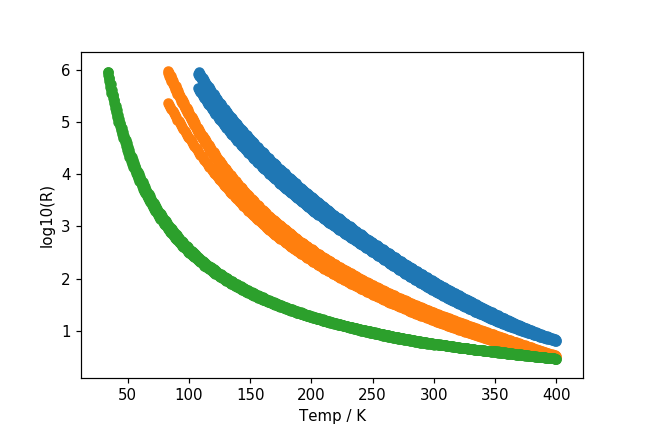

In [4]:
# Sanity check, plotting on a log scale
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("log10(R)")
plt.scatter(TR1[:,0],np.log10(TR1[:,1]))
plt.scatter(TR2[:,0],np.log10(TR2[:,1]))
plt.scatter(TR3[:,0],np.log10(TR3[:,1]))

In [5]:
import numpy as np
import scipy.constants
#
# This function performs fitting of a single R(T) temperature dataset to
# the functional form
# ln(R) = -Ea/2k (1/T)^n + ln(R0)
# which is ln(R) = m * (1/T)^n + b
# Where R is resistance, k is boltzmann's constant, Ea
# is the gap/activation energy, and n is a chosen power law.
# m and b are the slope and intercept of the linearized equation.
#
# The optional input parameter invTmin specifies a minimum value of 1/T^n
# to be included in the linear fit.
#
# It returns:
# 0. -2*m*k^n in units of eV^n [=Ea if n = 1]
# 1. 1/T^n
# 2. ln(R)
# 3. ln(R)_linfit
# 4. linfit parameters
#
def fitRT(temp,R,invTmin=0.0,Tpower=1.0):
    invT = 1/temp**Tpower
    lgR = np.log(R)
    fit = np.polyfit(invT[invT>invTmin],lgR[invT>invTmin],1)
    gap = 2.0*scipy.constants.Boltzmann**Tpower*fit[0]/scipy.constants.elementary_charge**Tpower
    return [gap,invT,lgR,np.polyval(fit,invT),fit]

<IPython.core.display.Javascript object>


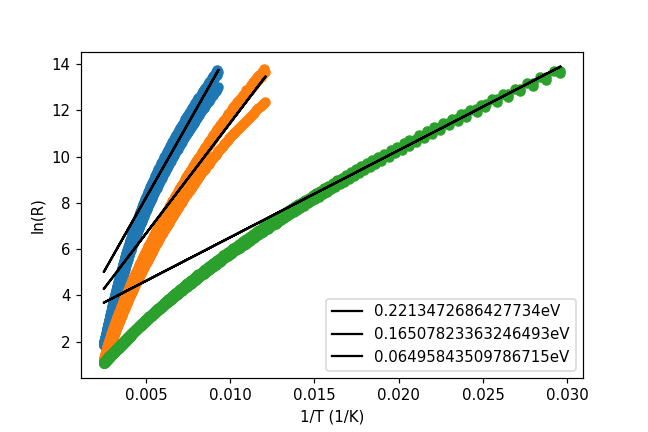

In [6]:
#
# Automatic fitting and plotting of fitting all three dataset to Arrhenius equations
#
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],invTmin=TRarr[0])
    plt.xlabel("1/T (1/K)")
    plt.ylabel("ln(R)")
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],fR[3],'k',label=str(fR[0])+"eV")
plt.legend()

<IPython.core.display.Javascript object>


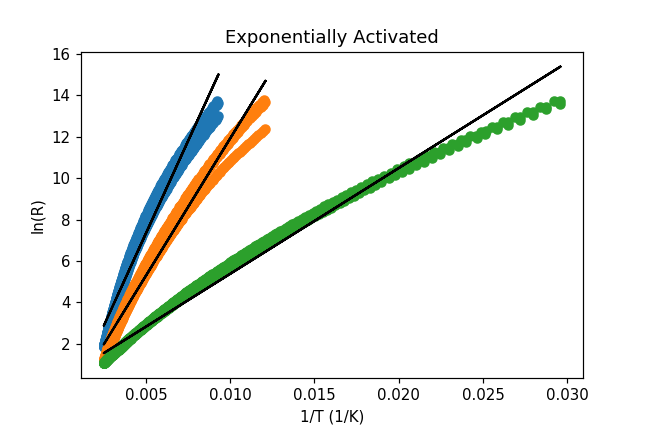

<IPython.core.display.Javascript object>


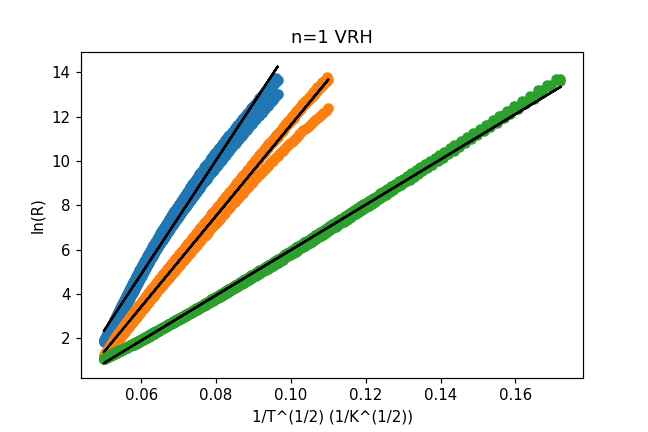

<IPython.core.display.Javascript object>


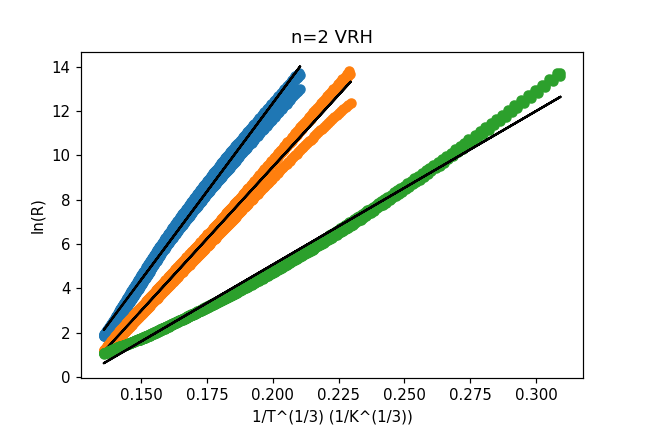

<IPython.core.display.Javascript object>


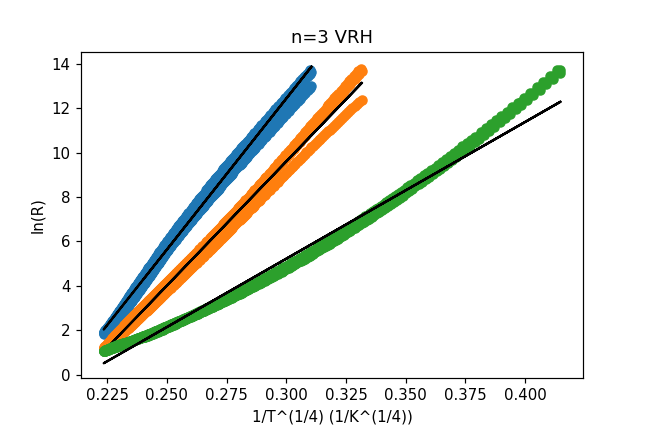

In [7]:
#
# This section carries out the analysis for Boltzmann activated behavior, as
# well as Mott variable range hopping.
# Mott variable range hopping produces a linear fit with
# ln(R) vs 1/T^(1/(n+1)) where n = 1,2,3 is the effective dimensionality.
# Note that n = 0 yields 1/T^1 (= Boltzmann activated behavior)
#
%matplotlib notebook
import matplotlib.pyplot as plt
# 1/T
plt.figure()
plt.title("Exponentially Activated")
plt.xlabel("1/T (1/K)")
plt.ylabel("ln(R)")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1.0)
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],fR[3],'k', label=str(fR[0])+" eV")
# 1/T^(1/(n+1)) n = dimensionality (1,2,3)
# n = 1
plt.figure()
plt.title("n=1 VRH")
plt.xlabel("1/T^(1/2) (1/K^(1/2))")
plt.ylabel("ln(R)")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1/(1+1))
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],fR[3],'k', label=str(fR[0])+" eV^(1/2)")
# 1/T^(1/(n+1)) n = dimensionality (1,2,3)
# n = 2
plt.figure()
plt.title("n=2 VRH")
plt.xlabel("1/T^(1/3) (1/K^(1/3))")
plt.ylabel("ln(R)")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1/(2+1))
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],fR[3],'k', label=str(fR[0])+" eV^(1/3)")
# 1/T^(1/(n+1)) n = dimensionality (1,2,3)
# n = 3
plt.figure()
plt.title("n=3 VRH")
plt.xlabel("1/T^(1/4) (1/K^(1/4))")
plt.ylabel("ln(R)")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1/(3+1))
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],fR[3],'k', label=str(fR[0])+" eV^(1/4)")